## B-Splines for KAN

This is Part 1 of the tutorial series on understanding Kolmogorov-Arnold Networks (KAN) using toy examples.

In this notebook, we will focus on understanding B-splines, which are used as activation fuctions in KAN [1]. To do so, we will look at toy examples and gradually build our understanding about the B-splines.

Specifically, we will look at 
1. What are B-splines and how are they constructed mathematically?
2. How are B-splines used for functional approximation?

[[1] Liu et al. 2024, KAN: Kolmogorov-Arnold Networks](https://arxiv.org/abs/2404.19756)

In [3]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## B-Splines

#### What are Splines?
Splines are a transformation that maps a set of *control points* to a regular, smooth curve. Given a series of such control points, we aim to create a curve that generally follows the shape of these points.

In constructing this curve, we must stick to several constraints, primarily related to continuity measures such as C1, C2,..., Cn. C1 and C2 measures are specially important in deep learning as we require well-defined functions that can be differentiated to obtain gradients necessary for backpropagation. Several splines have been defined in the literature with varying continuity measures. 

For a comprehensive understanding of splines and continuity measures, I recommend watching [this excellent video on Continuity of Splines](https://www.youtube.com/watch?v=jvPPXbo87ds) by Freya Holmér.

#### What are B-splines?

B-Splines (basis splines) form a class of C2 continuous curves, meaning their second derivatives are continuous and well-defined everywhere. If you were to plot the second derivative, it would be smooth without discontinuities. This fact beautifully lends KANs based on B-splines to be optimized using second-order optimization methods such as LBFGS. 

#### B-Spline Parameters:

A B-spline is defined by two parameters:

1. **Order (k)**: The curve's order.
    - k = 0: Uses the nearest control point directly. This lacks C0 continuity due to abrupt changes.
    - k = 1: Linearly interpolates between two control points.
    - k = 2: Uses a quadratic transformation to account for three control points.
    - k = 3: Applies a cubic transformation using four points, and so forth.


2. **Control Points**: Pre-specified points based on which curve is built. These points are treated in a conventional sense, much like one would in Euclidean space.


#### How are B-splines used to learn activation functions?

Authors use learnable 2D B-splines to learn activation function for each feature. The features can be the raw input features or the outputs of intermediate layers that are fed into the subsequent layer. The control points (referred to as a `grid`) are specified in 1D. The spline order (often k=3) is fixed. The goal is to manipulate the influence of control points (through learnable coeffecients) to determine the y-values that result in the accurate prediction on the downstream task.

#### B-Splines Mathematically

The workhorse of B-splines are basis functions $N_{i,k}(x): \mathcal{R} \rightarrow \mathcal{R}$ defined for each control point $i$ and the spline-order $k$. For a spline-order $k$, the scalar input $x \in \mathcal{R}$ is converted to "features" using the basis functions. These features are combined using learnable coefficients to result in a scalar output $\in \mathcal{R}$. 

**Cox-De Boor Recursion Formula**

The Cox-De Boor ***recursion formula*** provides a method to calculate the B-spline basis functions of degree $k$. 


**Base Case**

For $k=0$, the basis functions results in a one-hot encoding vector with a value of $1$ at the $i^{th}$ control point $t_i$ less than or equal to the scalar input $x$.

$$
N_{i,0}(x) = 
   \begin{cases} 
   1 & \text{if } t_i \leq x < t_{i+1} \\
   0 & \text{otherwise}
   \end{cases}
$$

If we define M control points, $i \in \{0, 1, 2, ..., M-1\}$, there will be a total of $M$ features corresponding to each scalar input $x$.

**Recursive Step**

The subsequent cases results in features described as follows

$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $

Here, for M control points, $i \in \{0, 1, 2, ..., M-k-1\}$, resulting in a total of $M-k$ basis functions for each scaler input. Authors use the extension of `grid` to increase the control points at the two extremes, resulting in a total of $M$ basis functions and hence $M$ learnable coefficients for each B-spline. We will see the effect of grid extension later in this tutorial.

### Notes:
- The control points $t_i$ must be non-decreasing.
- Each basis function $N_{i,k}(x)$ is non-zero only within the interval $ [t_i, t_{i+k+1}]$.
- ***Why does it generate smooth and continuous curves?***:  The B-spline curves are constructed by linearly combining the basis functions with control points. This also result in continuous curves exhbiting a key property of locality. This means that modifying a specific section of the curve, for example, from \(t_2\) to \(t_5\), does not affect the remainder of the curve. This localized influence is why KANs are resistant to catastrophic forgetting, as the input from various data distributions only impacts the curve locally.



#### B-Splines Programmatically

In this section, we will plot the basis functions to see their behavior as the spline order is increased. 

In [5]:
# Here, we define the control points. 
grid = torch.linspace(-1, 1, steps=10)

# we take the entire domain to plot the basis function as a function of x
x = torch.linspace(-1, 1, steps=1000) 

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

# Base case
k = 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

# Other cases
k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42

Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])


In [6]:
print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

k=0, number of basis functions: 9
k=1, number of basis functions: 8
k=2, number of basis functions: 7
k=3, number of basis functions: 6


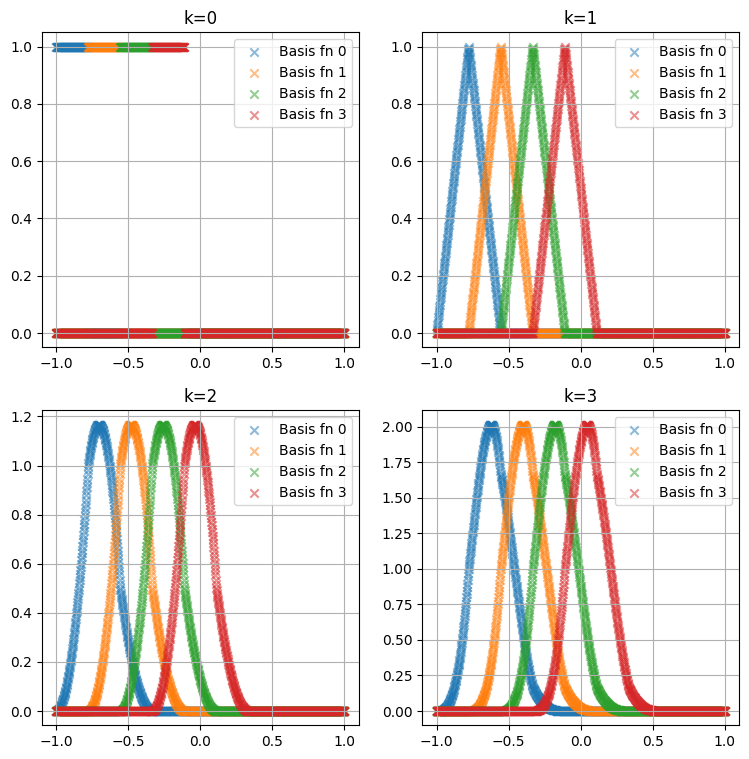

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:
        ax.scatter(x, value[:, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

**Observations**

- There are a total of $\#control\_points - k - 1$ basis functions. Think of these basis functions as features for a particular scalar input. 
- Each basis function is non-zero over a specific range, defined by the corresponding control points
- $K = 0$ has step basis functions as expected for one-hot encoded vectors
- $K = 1$ has piecewise linear basis functions
- $K \geq 2$ has non-linear basis functions
- $K=2$ and $K=3$ looks same, but are they? Let's look at the max non-zero values in both the cases

In [8]:
import collections
# value3 is [number of samples, number of basis functions]
# we check how many of the cols are nonzero corresp. to each sample

value3_counts = collections.Counter(torch.where(value3 !=0)[0].tolist())
value4_counts = collections.Counter(torch.where(value4 !=0)[0].tolist())

print('min non-zero values in k=2: ',min(value3_counts.values()))
print('max non-zero values in k=2: ',max(value3_counts.values()))
print('max non-zero values in k=3: ',max(value4_counts.values()))
print('min non-zero values in k=3: ',min(value4_counts.values()))

min non-zero values in k=2:  1
max non-zero values in k=2:  3
max non-zero values in k=3:  4
min non-zero values in k=3:  1


#### Extending the Grid for B-Splines Programatically

We also observe that not all inputs have the same number of non-zero basis functions. For instance, the basis functions near the boundaries of the input domain often have fewer non-zero basis functions. To address this, the authors extend the grid, ensuring that all features within the input domain have an equal number of non-zero basis functions.

The grid is extended by $k$ control points on each side, allowing the points at the extremes to have the same number of basis functions as those within the central part of the domain.

Next, let's explore how this extension is implemented programmatically. We extend grid once in the beginning of the evaluation. 

In [9]:
# extend grid (pseudocode)
grid = torch.linspace(-1, 1, steps=5)
print('old grid:', grid, grid.shape)
k = 2
n_intervals = grid.shape[0] - 1
bucket_size = (grid[-1] - grid[0]) / n_intervals

for i in range(k):
    grid = torch.cat([grid[:1] - bucket_size, grid], dim=0)
    grid = torch.cat([grid, grid[-1:] + bucket_size], dim=0)
print('new grid:', grid, grid.shape)

old grid: tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000]) torch.Size([5])
new grid: tensor([-2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,  1.5000,
         2.0000]) torch.Size([9])


We will write the above code in functions for the ease of use in the subsequent notebooks. 

In [10]:
def extend_grid(grid, k):
    """
    Extends the grid on either size by k steps

    Args:
        grid: number of splines x number of control points
        k: spline order

    Returns:
        new_grid: number of splines x (number of control points + 2 * k)
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid
    

Let's repeat the above exercise but with extension of grid.

In [20]:
def eval_basis_functions(x_eval, grid, k):
    """
    Returns the value of basis functions defiend for order-k splines and control points defined in `grid`. 

    Args:
        x_eval: number of samples x number of dimensions
        grid: number of splines x number of control points
        k (scalar): order of spline

    Returns:
        bases: number of samples x number of dimensions x number of basis functions
    """
    grid_ = extend_grid(grid, k)
    # Reshape so that each x can be compared to each control point
    grid_ = grid_.unsqueeze(dim=2)
    x_ = x_eval.unsqueeze(dim=1)
    
    for idx in range(k+1):
        if idx == 0:
            bases = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]) * 1.0 # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x_ - grid_[:, :-(idx+1)]) / (grid_[:, 1:-idx] - grid_[:, :-(idx+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idx+1):] - x_) / (grid_[:, (idx+1):] - grid_[:, 1:-idx]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1, 2) * 1.0

Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


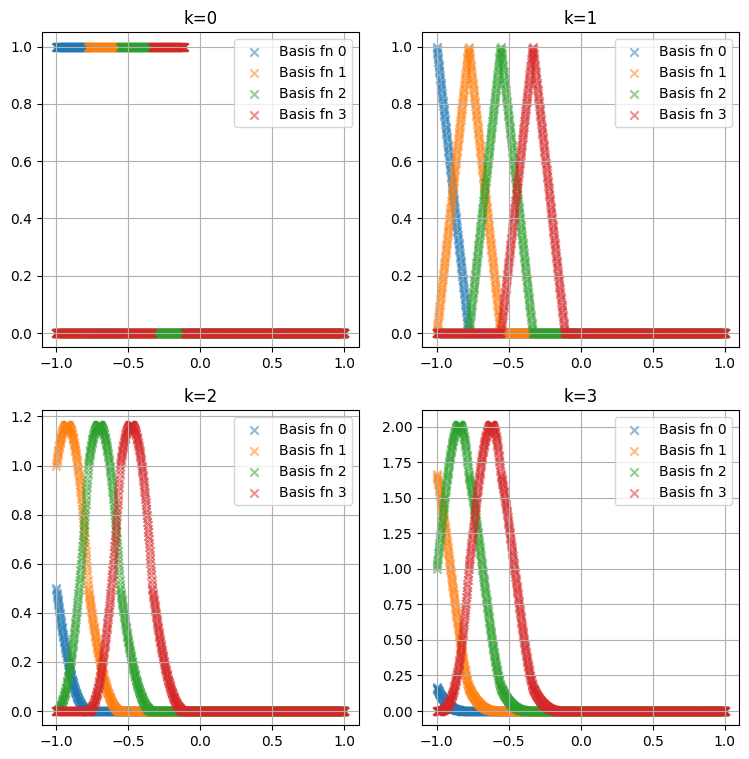

In [13]:
grid = torch.linspace(-1, 1, steps=10)
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)


value1 = eval_basis_functions(x_, grid_, k=0)

value2 = eval_basis_functions(x_, grid_, k=1)

value3 = eval_basis_functions(x_, grid_, k=2)

value4 = eval_basis_functions(x_, grid_, k=3)

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:  
        ax.scatter(x, value[:, 0, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

Finally, we see that even the boundary points get the same number of non-zero basis functions.

#### Learning the Activation Function, i.e., Coefficients

Now, let's explore whether we can learn the coefficients to emulate certain well-defined functions, with or without noise.

Formally, we define $ f(x) = \sum_{i=0}^{n} c_i \cdot N_{i, k}(x) = \sum_{i=0}^{n} c_i \cdot N_i(x) $.

Given $ x $, we will compute $ N_i(x) $ deterministically. Since we already have a predefined $ f(x) $, this presents a straightforward linear equation model to solve these equations: $ \min_{\mathbf{c}} |\mathbf{Nc} - f(x)| $. We will use `torch.linalg.lstsq` to solve for $ \mathbf{c} $.

Next, let's explore how to use a zero-order spline for predictions.

In [15]:
fn = lambda x: torch.sin(torch.pi * x) # define a function that we need to match
coeff1 = torch.linalg.lstsq(value1.squeeze(1), fn(x))

In [16]:
coeff1 # We need to use solution from this object. 

torch.return_types.linalg_lstsq(
solution=tensor([-3.3222e-01, -8.4700e-01, -9.6457e-01, -6.2745e-01,  2.8415e-09,
         6.2745e-01,  9.6439e-01,  8.5008e-01,  3.3801e-01]),
residuals=tensor([]),
rank=tensor(9),
singular_values=tensor([]))

Let's put it together to see the predictions

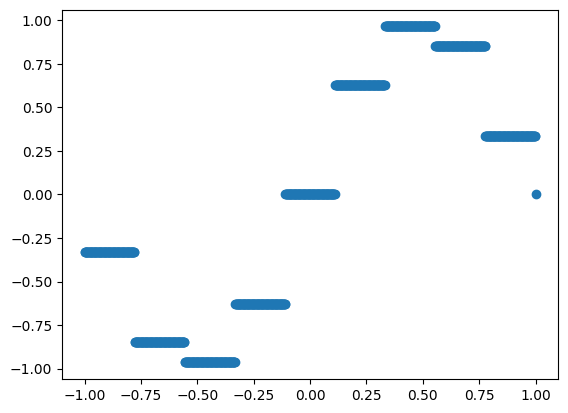

In [17]:
fn = lambda x: torch.sin(torch.pi * x) # define a function that we need to match
coeff1 = torch.linalg.lstsq(value1.squeeze(1), fn(x)).solution # find the coefficients 

y_pred = torch.einsum('i, ji -> j', coeff1, value1.squeeze(1)) # use these coefficients to evaluate y
plt.scatter(x, y_pred)

#### How does $k$ impact the learning accuracy?

Let's see the effect of order on estimations of various functions.

We consider two functions -- 
1. $\sin(\pi \times x)$
2. $\sin(\pi \times e^{x})$

We consider four values of $k \in \{0, 1, 2, 3\}$.

**Case 1:** When we don't extend the grid

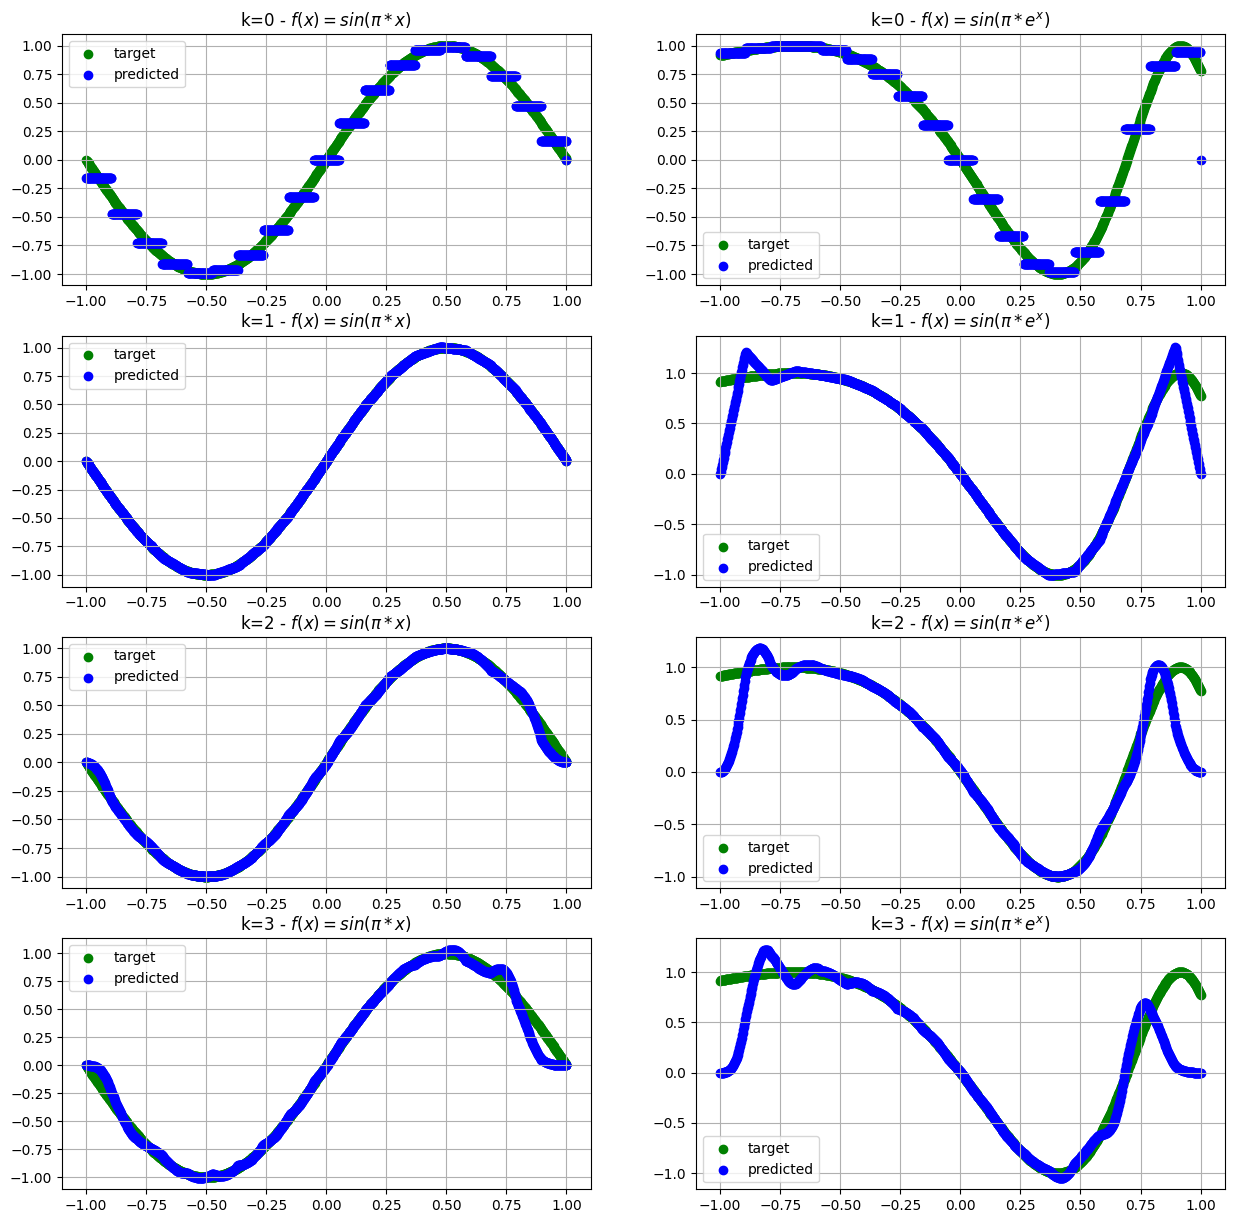

In [18]:
# notice the increase in the grid points to 100
grid = torch.linspace(-1, 1, steps=20) 
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

k = 0 # This gives us basis functions for order 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42


fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [(value1 * 1.0, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value, fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

**Observations**

1. As $ k $ increases, the fit near the boundaries is not perfect due to boundary effects, as previously discussed. There are insufficient boundary points in these areas. This issue can be minimized by increasing the number of control points, as we will explore next.
2. As $ k $ increases, the fit improves significantly in the middle of the domain.

**Case 2:** When we extend the grid on either side

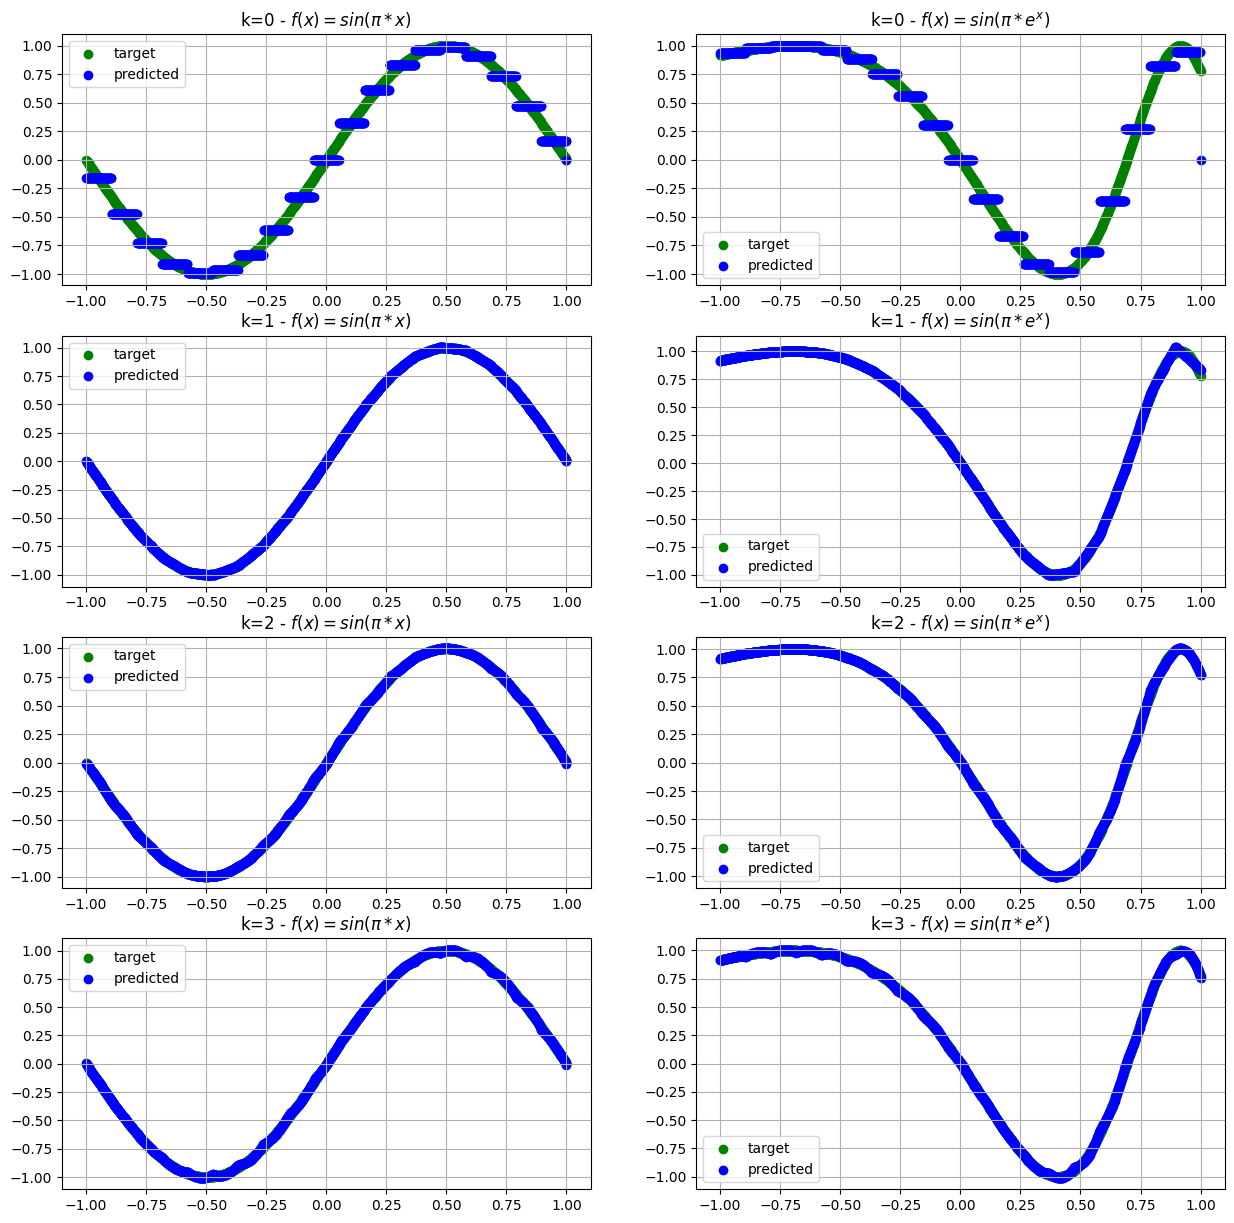

In [21]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value.squeeze(1), fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

Notice how increasing the number of control points has improved the overall fit neaer the boundaries. 

**Case 3:** Usually, the real data is messy. How will the noise in the function estimation look like?


In [25]:
y_target.shape, value.shape

(torch.Size([1000]), torch.Size([1000, 1, 19]))

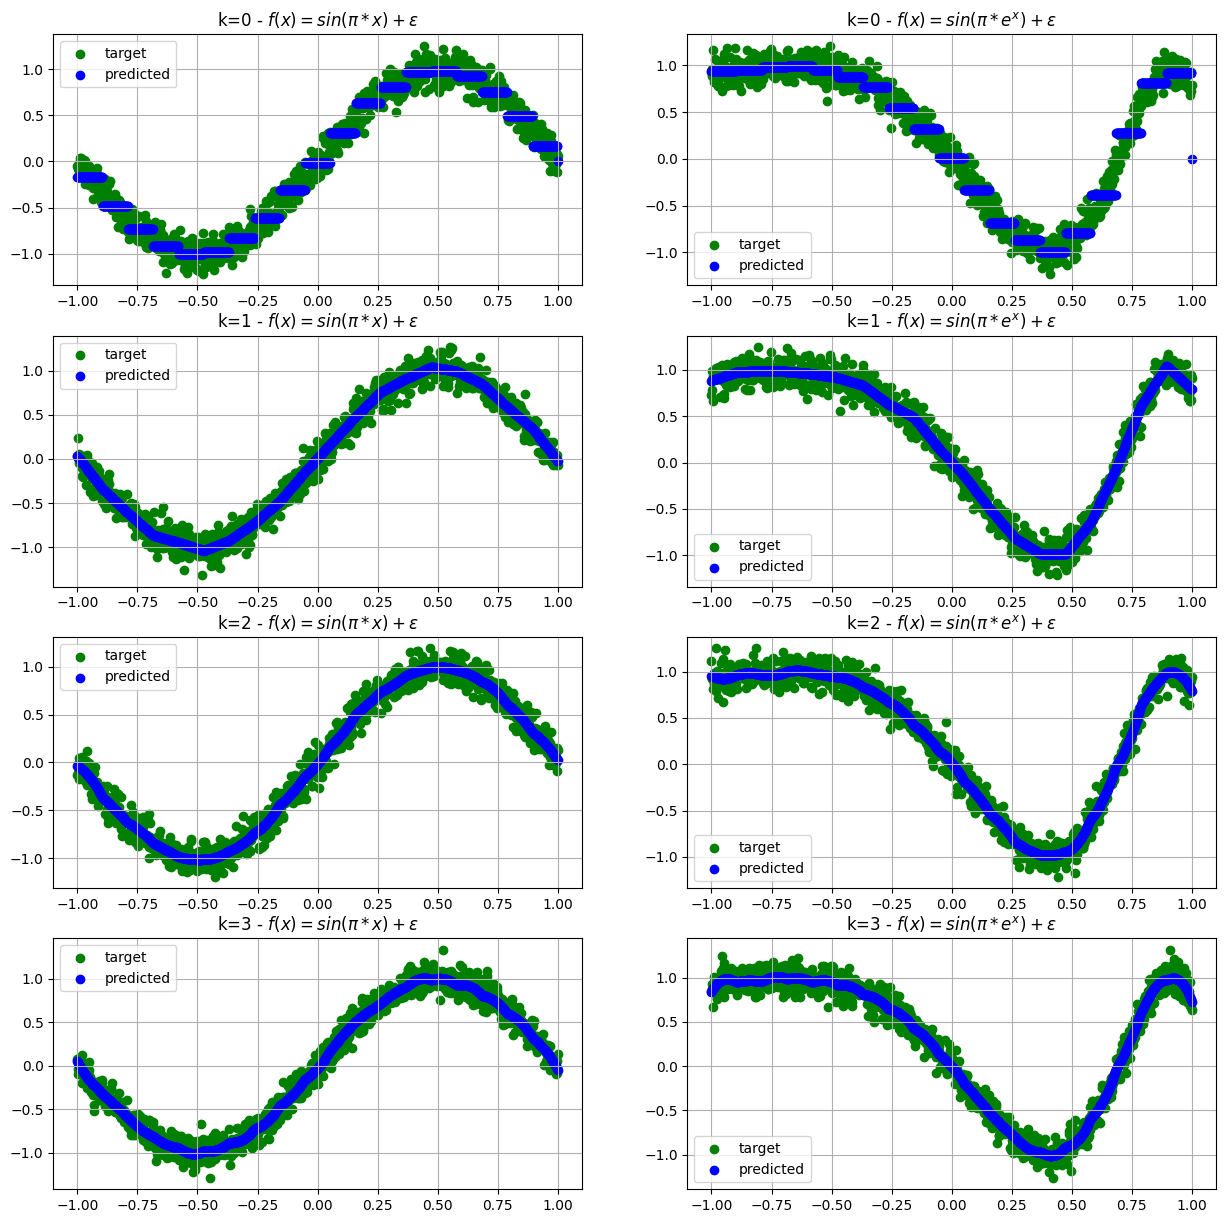

In [27]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*x) + \epsilon$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*e^{x}) + \epsilon$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]

        y_target = fn(x)
        coeff = torch.linalg.lstsq(value.squeeze(1), y_target).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, y_target, color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

#### Summary

1. We learned how B-splines are defined using control points and spline order.
2. We explored the concept of learning arbitrary activation functions using B-splines. 
3. We examined how the accuracy of function fitting may be influenced through control points and spline order

This tutorial explored a [1, 1] KAN network configuration, which consisted of one input (first index), one output (last index), and one spline activation function in the middle.

#### What's Next?

We will expand our exploration to see how two units can be stacked on top of each other resulting in [1, 1, 1] KAN network configuration.